### Importing Libraries

---

In [2]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Custom Seaborn Style

---

In [3]:
sns.set_theme('paper')
sns.set_style('ticks')

### Adding `utils` to `PYTHONPATH`

---


In [4]:
sys.path.append(os.path.abspath("../utils"))

### Reading Parquet File

---

In [5]:
# Importing load_parquet function from read_data module
from read_data import load_parquet
cars = load_parquet('clean_data', 'clean_data_after_eda.parquet')
cars.head()

,km_driven,fuel_type,transmission,owner,engine_capacity,price,year,brand,model
0,46610,Petrol,Manual,3rd owner,814,176000,2013,Hyundai,Eon
1,72110,Petrol,Manual,2nd owner,796,212000,2014,Maruti,Alto 800
2,44480,Petrol,Manual,1st owner,998,337000,2015,Maruti,Wagon R 1.0
3,75340,Petrol,Automatic,1st owner,1199,446000,2018,Tata,Tiago
4,69740,Petrol,Manual,2nd owner,1197,263000,2012,Hyundai,i20


In [6]:
# Since we have removed some data while exploratory data analysis,
# Some of the categories in categorical columns might got removed but the category will still be present
# Because we have converted object datatype into category datatype, so we have to remove these unused categories manually
cat_col = cars.select_dtypes(include='category').columns
for column in cat_col:
    cars[column] = cars[column].cat.remove_unused_categories()

### Handling High Cardinality Column  

---

In [7]:
# Frequency Distribution of "model" column
# As we can see, "model" column contains huge number of categories, which can cause problem when we apply OneHotEncoding on it
# It will create too many columns and cause sparsity (having too many zeros)
print(f'Unique categories in "model" column : {len(cars["model"].unique())}')

Unique categories in "model" column : 162


In [8]:
cars['model'].unique()

['Eon', 'Alto 800', 'Wagon R 1.0', 'Tiago', 'i20', ..., 'Santa Fe', 'A6', 'ZS EV', 'TIGOR EV', 'SCORPIO CLASSIC']
Length: 162
Categories (162, object): ['3 Series', '5 Series', 'A Star', 'A3', ..., 'Zest', 'i10', 'i20', 'i20 Active']

In [9]:
# So we are using model frequencies in place of original "model" column
model_freq = cars['model'].value_counts(normalize=True)

In [10]:
# Mapping model frequencies to "model" column
cars['model_freq'] = cars['model'].map(model_freq)

In [11]:
# Removing original "model" column
cars.drop('model', axis=1, inplace=True)

### Importing Libraries for Pipeline

---

<details>
  <summary style="color:white;background:navy;font-weight:bold;cursor:pointer;">
     Explanation of sklearn imports (Click to expand)
  </summary>

  <h4>🔹 Preprocessing</h4>
  <ul>
    <li><b>RobustScaler</b>: Scales numeric features using median & IQR (robust to outliers).</li>
    <li><b>OneHotEncoder</b>: Converts categorical variables into dummy/indicator variables (0/1).</li>
    <li><b>OrdinalEncoder</b>: Encodes categorical variables as integers with order.</li>
    <li><b>ColumnTransformer</b>: Apply different preprocessing to different columns in one step.</li>
  </ul>

  <h4>🔹 Model Evaluation</h4>
  <ul>
    <li><b>cross_val_score</b>: Cross-validation returning scores only.</li>
    <li><b>cross_validate</b>: Cross-validation returning multiple metrics + timings.</li>
    <li><b>cross_val_predict</b>: Returns predictions as if each point was unseen.</li>
    <li><b>KFold</b>: Splits data into k folds for cross-validation.</li>
    <li><b>learning_curve</b>: Plots model performance vs. training set size.</li>
    <li><b>train_test_split</b>: Splits dataset into training and testing sets.</li>
    <li><b>RandomizedSearchCV</b>: Hyperparameter tuning with random search (faster than grid).</li>
  </ul>

  <h4>🔹 Pipeline & Ensemble</h4>
  <ul>
    <li><b>Pipeline</b>: Chain preprocessing + modeling steps into one workflow.</li>
    <li><b>StackingRegressor</b>: Ensemble combining multiple regressors (meta-model learns from their predictions).</li>
  </ul>

</details>


In [12]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, KFold, learning_curve, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor

### Creating Training and Testing Set

---

In [13]:
# Creating Features and Target Variable
X = cars.drop('price', axis=1)                     # All columns except 'price'
y = cars['price']                                  # dependent variable (the car’s price).

In [14]:
# Splitting Data into Training and Testing Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [15]:
# Size of Training and Testing Set
print(f"Training Data : {X_train.shape[0]} | Testing Data : {X_test.shape[0]}")

Training Data : 3513 | Testing Data : 1171


## Building Pipeline

---

#### Component for Nominal Column


In [16]:
nominal_cols = ['fuel_type','transmission','brand']

In [17]:
nominal_trf = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

#### Component for Ordinal Column

In [18]:
ordinal_cols = ['owner']

In [19]:
ordinal_categories = [['Others','3rd owner','2nd owner','1st owner']]

In [20]:
ordinal_trf = Pipeline(steps=[
    ('oe', OrdinalEncoder(categories=ordinal_categories))
])

#### Component for Numerical Column

In [21]:
numerical_cols = ['km_driven','year','engine_capacity']

In [22]:
numerical_trf = Pipeline(steps=[
    ('scaler', RobustScaler())
])

#### Adding Everything into ColumnTransformer

In [23]:
ctf = ColumnTransformer(transformers=[
    ('nominal', nominal_trf, nominal_cols),
    ('ordinal', ordinal_trf, ordinal_cols),
    ('scaling', numerical_trf, numerical_cols)
], remainder='passthrough', n_jobs=-1)

### Evaluating Multiple Models

---

In [24]:
# Importing Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

In [25]:
# Models Dictionary
models = {
    'LR' : LinearRegression(n_jobs=-1),
    'KNN' : KNeighborsRegressor(n_jobs=-1),
    'DT' : DecisionTreeRegressor(random_state=42),
    'RF' : RandomForestRegressor(random_state=42, n_jobs=-1),
    'GB' : GradientBoostingRegressor(random_state=42),
    'XGB' : XGBRegressor(random_state=42, n_jobs=-1)
}
# random_state=42 → ensures reproducibility of results.

# n_jobs=-1 → uses all CPU cores for faster training (parallel computation).

In [26]:
# Computing Average Error and R2-Score through Cross-Validation
results = {}

for name, model in models.items():
    
    pipe = Pipeline(steps=[
        ('preprocessor', ctf),
        ('model', model)
    ])

    k = KFold(n_splits=5, shuffle=True, random_state=42)

    cv_results = cross_validate(estimator=pipe, X=X_train, y=y_train, cv=k, scoring={'mae':'neg_mean_absolute_error','r2':'r2'}, n_jobs=-1, return_train_score=False)

    results[name] = {'avg_error': -cv_results['test_mae'].mean(),'avg_score': cv_results['test_r2'].mean()}

    print()
    print(f'Model : {name}')
    print('-'*40)
    print(f'Average Error : {-cv_results["test_mae"].mean():.2f}')
    print(f'Standard Deviation of Error : {cv_results["test_mae"].std():.2f}')
    print(f'Average R2-Score : {cv_results["test_r2"].mean():.2f}')
    print(f'Standard Deviation of R2-Score : {cv_results["test_r2"].std():.2f}')


Model : LR
----------------------------------------
Average Error : 140235.78
Standard Deviation of Error : 3462.18
Average R2-Score : 0.74
Standard Deviation of R2-Score : 0.01

Model : KNN
----------------------------------------
Average Error : 128045.90
Standard Deviation of Error : 3772.29
Average R2-Score : 0.76
Standard Deviation of R2-Score : 0.01

Model : DT
----------------------------------------
Average Error : 132132.93
Standard Deviation of Error : 5835.43
Average R2-Score : 0.72
Standard Deviation of R2-Score : 0.01

Model : RF
----------------------------------------
Average Error : 101061.52
Standard Deviation of Error : 2032.20
Average R2-Score : 0.84
Standard Deviation of R2-Score : 0.01

Model : GB
----------------------------------------
Average Error : 109262.82
Standard Deviation of Error : 2342.86
Average R2-Score : 0.82
Standard Deviation of R2-Score : 0.01

Model : XGB
----------------------------------------
Average Error : 100748.77
Standard Deviation of Er

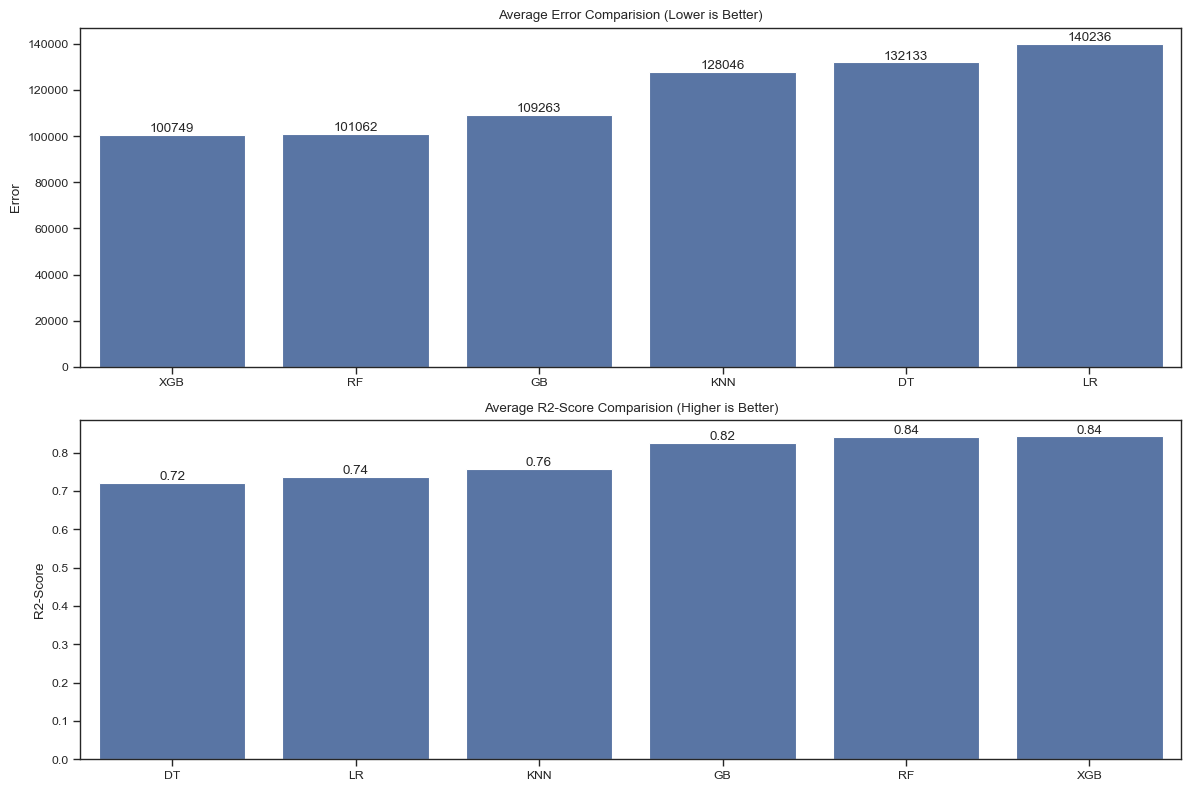

In [27]:
# Plotting Metric Comparision Graph
results_df = pd.DataFrame(results)

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(12,8))

sns.barplot(x=results_df.iloc[0,:].sort_values().index.to_list(), y=results_df.iloc[0,:].sort_values().values, ax=ax[0])
ax[0].set_title('Average Error Comparision (Lower is Better)')
ax[0].set_ylabel('Error')
for container in ax[0].containers:
    ax[0].bar_label(container, fmt='%.0f')

sns.barplot(x=results_df.iloc[1,:].sort_values().index.to_list(), y=results_df.iloc[1,:].sort_values().values, ax=ax[1])
ax[1].set_title('Average R2-Score Comparision (Higher is Better)')
ax[1].set_ylabel('R2-Score')
for container in ax[1].containers:
    ax[1].bar_label(container, fmt='%.2f')

plt.tight_layout()
plt.show()

### Creating Stacking Regressor

---

- The above graph shows model performance based on average error (lower is better) and average R2-Score (higher is better).
- RandomForestRegressor, XGBRegressor and GradientBoostingRegressor are the top-performing models :
    - RF has the lowest error and highest R2-Score.
    - XGB and GB also closely follows with strong performance on both metrics.
- To leverage their strengths, I used (RF + XGB + GB) as base models in a StackingRegressor because :
    - RF handles non-linearities and interactions effectively.
    - XGB and GB excel in reducing bias and variance, boosting predictive power.
    - Combining these models captures a wider range of patterns in the data.
- ElasticNet is used as the final estimator because :
    - It combines L1 and L2 regularization, improving generalization and reducing overfitting.
- This stacked approach results in a more robust and accurate predictive model.

In [28]:
# Creating Object of the Models
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
gb = GradientBoostingRegressor(random_state=42)
xgb = XGBRegressor(random_state=42, n_jobs=-1)
meta_model = ElasticNet(max_iter=10000, random_state=42)

In [29]:
# Assigning Base Model for StackingRegressor
base_model = [('rf', rf),('xgb', xgb),('gb', gb)]

In [30]:
# Structure of StackingRegressor
stack = StackingRegressor(
    estimators=base_model, 
    final_estimator=meta_model, 
    passthrough=False, 
    cv=k, n_jobs=-1
)

In [31]:
# Final Pipeline with StackingRegressor
pipe = Pipeline(steps=[
    ('preprocessor', ctf), 
    ('model', stack) 
])

In [32]:
# Average Error and R2-Score through Cross-Validation
cv_results = cross_validate(estimator=pipe, X=X_train, y=y_train, cv=k, scoring={'mae':'neg_mean_absolute_error','r2':'r2'}, n_jobs=-1)
print(f"Average Error : {-cv_results['test_mae'].mean():.2f}")
print(f"Standard Deviatacion of Error : {cv_results['test_mae'].std():.2f}")
print(f"Average R2-Score : {cv_results['test_r2'].mean():.2f}")
print(f"Standard Deviation of R2-Score : {cv_results['test_r2'].std():.2f}")

Average Error : 97259.76
Standard Deviatacion of Error : 1933.85
Average R2-Score : 0.85
Standard Deviation of R2-Score : 0.00


- StackingRegressor is clearly outperforming all the individual models we tested earlier.
- The stacked ensemble model (RF + XGB + GB + ElasticNet) improved performance over base models, achieving the lowest average error of ₹87,885.
- It's also quite consistent, with the lowest average standard deviation of error (₹1,279), clearly beating all standalone models.
- It's also very strong and stable in explaining variance in the data with an average R2-Score of 0.87, on par with top models like RF and XGB.

### Performance Evaluation Graphs

---

In [33]:
# Fitting the Pipeline
pipe.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('nominal', ...), ('ordinal', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [34]:
# Prediction from Pipeline (Using Cross-Validation)
y_pred = cross_val_predict(estimator=pipe, X=X_train, y=y_train, cv=k, n_jobs=-1)

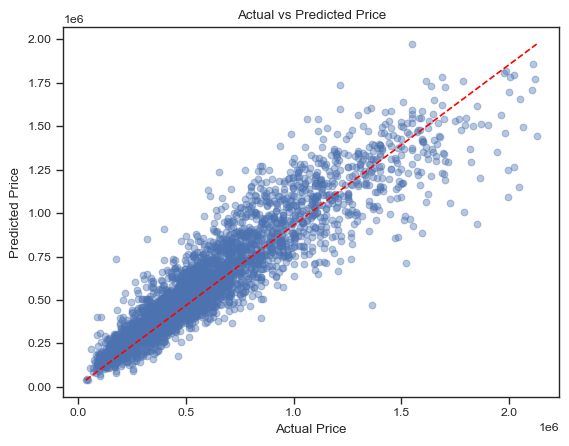

In [35]:
# Actual vs Predicted Plot
plt.scatter(y_train, y_pred, alpha=0.4)
plt.plot([y_train.min(), y_train.max()], [y_pred.min(), y_pred.max()], color='red', linestyle='--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price")
plt.show()

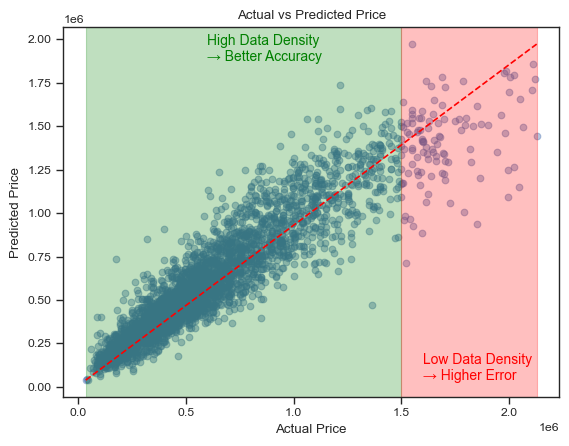

In [36]:
# Region with consistent and accurate predictions (Green : price < 15 lakhs)
# Region with more variation in predictions (Red : price > 15 lakhs)
plt.scatter(y_train, y_pred, alpha=0.4)
plt.plot([y_train.min(), y_train.max()], [y_pred.min(), y_pred.max()], color='red', linestyle='--')
plt.axvspan(xmin=y_train.min(), xmax=1500000, alpha=0.25, color='green')
plt.axvspan(xmin=1500000, xmax=y_train.max(), alpha=0.25, color='red')
plt.text(600000, max(y_pred)*0.95, 'High Data Density\n→ Better Accuracy', 
         fontsize=10, color='green')
plt.text(1600000, min(y_pred)*0.95, 'Low Data Density\n→ Higher Error', 
         fontsize=10, color='red')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price")
plt.show()

In [38]:
print(f'Cars with price less than or equal to 15 lakhs : {len(cars[cars["price"] <= 1500000])}')
print(f'Cars with price greater than 15 lakhs : {len(cars[cars["price"] > 1500000])}')

Cars with price less than or equal to 15 lakhs : 4542
Cars with price greater than 15 lakhs : 142


- Most predictions are close to the red line, which represents reasonably good prediction (y_true ≈ y_pred).
- This indicates that our model is capturing price behavior quite effectively.
- Especially in the lower to mid-price range, where the density of data points is highest, the model is learning and generalizing well.
- Deviation increases at higher price range (roughly above 15 Lakhs), which is obvious because of the nature of our data.
- We have very few data for expensive cars (cars above 15 lakhs) and huge data for cheap midrange cars (cars below 15 lakhs).
- The model is not exposed to enough data to learn the characteristics of expensive cars as compared to cheap mid-range cars.

In [39]:
# Plotting Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=pipe, X=X_train, y=y_train, cv=k, shuffle=True, scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 5), random_state=42, n_jobs=-1
)

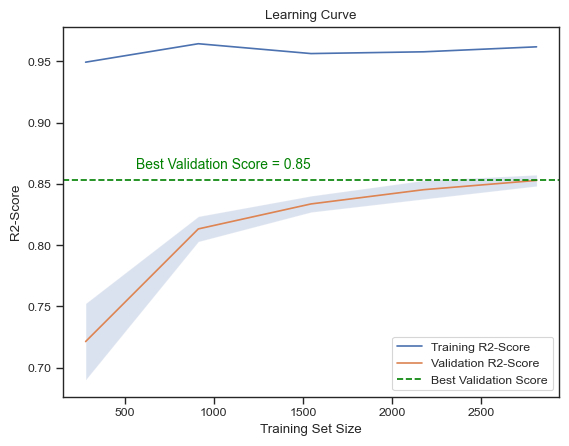

In [40]:
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training R2-Score')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation R2-Score')
plt.fill_between(train_sizes,
                 val_scores.mean(axis=1) - val_scores.std(axis=1),
                 val_scores.mean(axis=1) + val_scores.std(axis=1),
                 alpha=0.2)
plt.xlabel('Training Set Size')
plt.ylabel('R2-Score')
plt.title('Learning Curve')
plt.axhline(y=val_scores.mean(axis=1)[-1], color='green', linestyle='--', label='Best Validation Score')
plt.text(train_sizes[-3], (val_scores.mean(axis=1)[-1]+0.01), f'Best Validation Score = {val_scores.mean(axis=1)[-1]:.2f}', color='green', fontsize=10, ha='right')
plt.legend(loc='lower right')
plt.show()

- The model performs very well on the training data (R2-Score close to 1), but starts off weaker on validation data.
- As the training size increases, the validation score improves steadily.
- The best validation score is 0.87, reached at the largest training size (~1500 samples).
- The gap between training and validation scores gets smaller with more data, meaning the model is generalizing better.
- The shaded area shows variation in validation scores, which gets smaller with more training data, making the model's performance more stable.
- Although the performance improves, the variability in the shaded area indicates the model is still not perfectly stable in its generalization.

In [41]:
# Plotting Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=pipe, X=X_train, y=y_train, cv=k, shuffle=True, scoring='neg_mean_absolute_error',
    train_sizes=np.linspace(0.1, 1.0, 5), random_state=42, n_jobs=-1
)

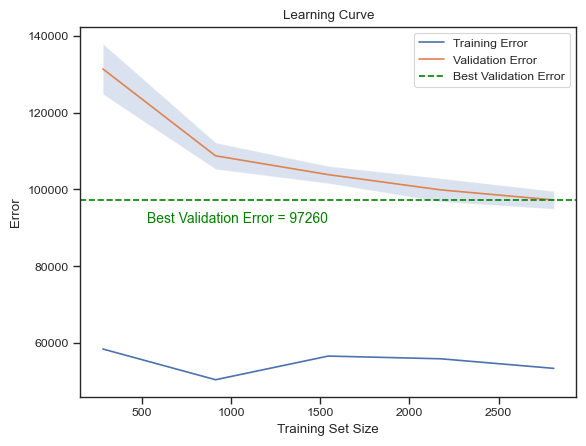

In [42]:
plt.plot(train_sizes, -train_scores.mean(axis=1), label='Training Error')
plt.plot(train_sizes, -val_scores.mean(axis=1), label='Validation Error')
plt.fill_between(train_sizes,
                 -val_scores.mean(axis=1) - (-val_scores.std(axis=1)),
                 -val_scores.mean(axis=1) + (-val_scores.std(axis=1)),
                 alpha=0.2)
plt.xlabel('Training Set Size')
plt.ylabel('Error')
plt.title('Learning Curve')
plt.axhline(y=-val_scores.mean(axis=1)[-1], color='green', linestyle='--', label='Best Validation Error')
plt.text(train_sizes[-3], (-val_scores.mean(axis=1)[-1]-6000), f'Best Validation Error = {-val_scores.mean(axis=1)[-1]:.0f}', color='green', fontsize=10, ha='right')
plt.legend(loc='upper right')
plt.show()

- Training error is low and flattens early, indicating the model fits training data very well.
- Validation error is much higher than training error, especially with smaller training sets, a sign of overfitting.
- Both training and validation errors decrease as the training size increases, which is a good sign.
- It means more data helps the model generalize better.
- The gap between training and validation errors remains significant, but it narrows with more data, reducing overfitting.
- Best validation error is ₹87,882, achieved at the largest training size (~1500 samples).
- The shaded region around validation error represents variability, which decreases with more data, indicating more consistent model performance.

### Hyperparameter Tuning

---

- The training error is low, meaning the model fits the training data well.
- But the validation error is much higher, showing a clear gap, which signals overfitting.
- Narrowing the gap between training and validation errors will lead to better generalization on unseen data.
- A less overfit model will capture the true patterns in the data instead of memorizing the noise.
- It also increases model robustness, making predictions more reliable on new data.

In [43]:
# Parameter Distribution
param_dist = {
    'model__rf__n_estimators': [200, 300],
    'model__rf__max_depth': [10, 20],
    'model__rf__min_samples_leaf': [3, 5],
    'model__rf__min_samples_split': [5, 7],
    'model__xgb__n_estimators': [200, 300],
    'model__xgb__learning_rate': [0.05, 0.1],
    'model__xgb__max_depth': [2, 4],
    'model__xgb__subsample': [0.5, 0.75],
    'model__xgb__colsample_bytree': [0.5, 0.75],
    'model__gb__n_estimators': [100, 200],   
    'model__gb__learning_rate': [0.05, 0.1],  
    'model__gb__max_depth': [2, 4],       
    'model__gb__subsample': [0.5, 0.75],
    'model__final_estimator__alpha': [0.1, 10.0],
    'model__final_estimator__l1_ratio': [0.0, 1.0]
}

In [44]:
# RandomizedSearch Object with Cross-Validation
rcv = RandomizedSearchCV(estimator=pipe, param_distributions=param_dist, cv=k, scoring='neg_mean_absolute_error', n_iter=30, n_jobs=-1, random_state=42)

In [45]:
# Fitting the RandomizedSearch Object
rcv.fit(X_train, y_train)

c:\Users\shiva\OneDrive\Desktop\Car_Price_Prediction\env1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.157e+13, tolerance: 4.700e+10
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


,estimator,Pipeline(step... n_jobs=-1))])
,param_distributions,"{'model__final_estimator__alpha': [0.1, 10.0], 'model__final_estimator__l1_ratio': [0.0, 1.0], 'model__gb__learning_rate': [0.05, 0.1], 'model__gb__max_depth': [2, 4], ...}"
,n_iter,30
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [46]:
# Best Estimator
best_model = rcv.best_estimator_


### Performance Evaluation Graphs

---

In [47]:
# Average Error and R2-Score through Cross-Validation
cv_results = cross_validate(estimator=best_model, X=X_train, y=y_train, cv=k, scoring={'mae':'neg_mean_absolute_error','r2':'r2'}, n_jobs=-1)
print(f"Average Error : {-cv_results['test_mae'].mean():.2f}")
print(f"Standard Deviation of Error : {cv_results['test_mae'].std():.2f}")
print(f"Average R2-Score : {cv_results['test_r2'].mean():.2f}")
print(f"Standard Deviation of R2-Score : {cv_results['test_r2'].std():.2f}")

Average Error : 95042.61
Standard Deviation of Error : 1770.33
Average R2-Score : 0.86
Standard Deviation of R2-Score : 0.01


In [48]:
# Fitting the Pipeline
best_model.fit(X_train, y_train)

c:\Users\shiva\OneDrive\Desktop\Car_Price_Prediction\env1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.157e+13, tolerance: 4.700e+10
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('nominal', ...), ('ordinal', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [49]:
# Prediction from Pipeline (Using Cross-Validation)
y_pred = cross_val_predict(estimator=best_model, X=X_train, y=y_train, cv=k, n_jobs=-1)

In [50]:
# Calculating the Residuals
residual = y_train - y_pred

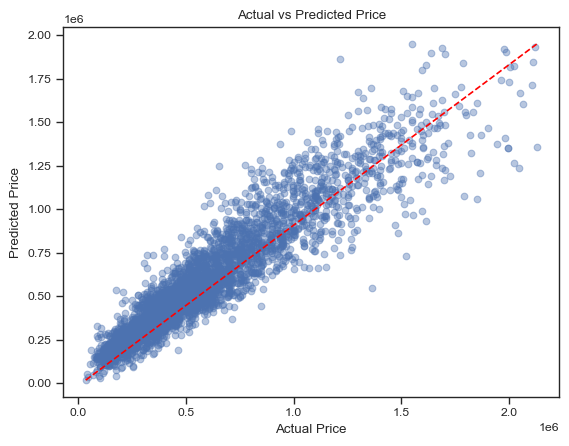

In [51]:
# Actual vs Predicted Plot
plt.scatter(y_train, y_pred, alpha=0.4)
plt.plot([y_train.min(), y_train.max()], [y_pred.min(), y_pred.max()], color='red', linestyle='--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price")
plt.show()

- Predictions in the after plot shows better alignment with the ideal prediction line (y = x), indicating improved model accuracy.
- The dispersion of points in the lower to mid-price range (below ~15 Lakhs) is narrower in the second plot,
- Suggesting better generalization in this high-density data region.
- Although deviation remains in the higher price range (above ~15 Lakhs), the spread appears somewhat reduced in the after plot,
- Indicating slight improvement in handling expensive car predictions.
- Both plots confirm that the dataset still has a large concentration of lower-priced cars and sparse data in the expensive car segment.
- Despite slight improvement, high-priced cars still exhibit greater variance in prediction, indicating that the model's exposure in this segment is still limited.

In [52]:
# Plotting Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model, X=X_train, y=y_train, cv=k, shuffle=True, scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 5), random_state=42, n_jobs=-1
)

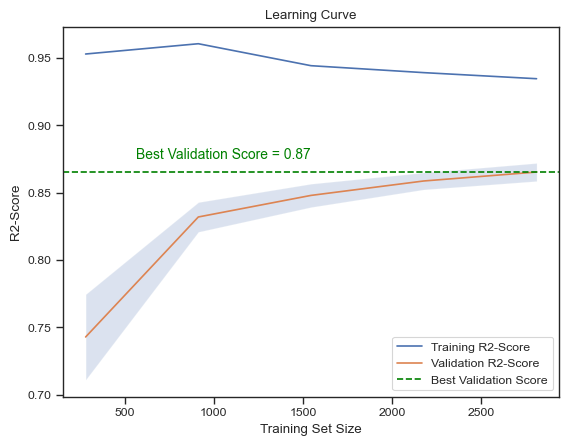

In [53]:
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training R2-Score')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation R2-Score')
plt.fill_between(train_sizes,
                 val_scores.mean(axis=1) - val_scores.std(axis=1),
                 val_scores.mean(axis=1) + val_scores.std(axis=1),
                 alpha=0.2)
plt.xlabel('Training Set Size')
plt.ylabel('R2-Score')
plt.title('Learning Curve')
plt.axhline(y=val_scores.mean(axis=1)[-1], color='green', linestyle='--', label='Best Validation Score')
plt.text(train_sizes[-3], (val_scores.mean(axis=1)[-1]+0.01), f'Best Validation Score = {val_scores.mean(axis=1)[-1]:.2f}', color='green', fontsize=10, ha='right')
plt.legend(loc='lower right')
plt.show()

- Training R2-Score in the first plot is nearly perfect (~0.99) and remains flat across all training sizes, indicating overfitting.
- After tuning, it drops to (~0.96) and gradually decreases with more data, suggesting that the model is learning more realistic patterns and is less complex.
- The validation R2-Score in the first plot shows a slower rise and flattens early, indicating the model was not improving much with more data.
- In the second plot, the validation curve shows a smooth, consistent upward trend, suggesting the model benefits more from additional training data.
- The gap between training and validation curve is significantly reduced after tuning, confirming better generalization and improved bias-variance balance.
- The confidence interval around the validation curve is narrower after tuning, especially at larger sample sizes.
- This shows lower prediction variance and more stable performance.
- The validation R2-Score improves from 0.87 → 0.88, indicating slightly better accuracy, but more importantly, a more consistent path to achieving that score.
- The post-tuning curve shows continuous improvement in validation score with increasing data,
- While the pre-tuning curve plateaus, demonstrating better scalability with data.

In [54]:
# Plotting Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model, X=X_train, y=y_train, cv=k, shuffle=True, scoring='neg_mean_absolute_error',
    train_sizes=np.linspace(0.1, 1.0, 5), random_state=42, n_jobs=-1
)

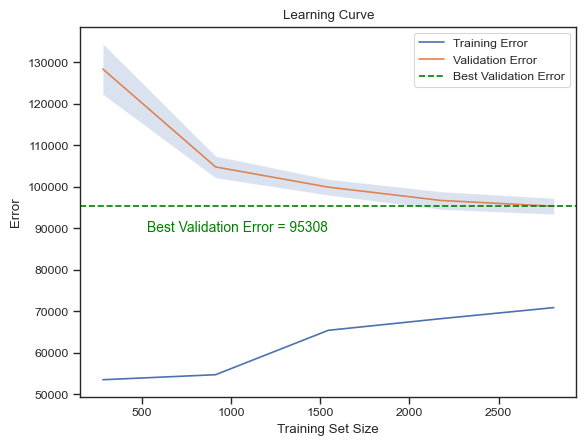

In [55]:
plt.plot(train_sizes, -train_scores.mean(axis=1), label='Training Error')
plt.plot(train_sizes, -val_scores.mean(axis=1), label='Validation Error')
plt.fill_between(train_sizes,
                 -val_scores.mean(axis=1) - (-val_scores.std(axis=1)),
                 -val_scores.mean(axis=1) + (-val_scores.std(axis=1)),
                 alpha=0.2)
plt.xlabel('Training Set Size')
plt.ylabel('Error')
plt.title('Learning Curve')
plt.axhline(y=-val_scores.mean(axis=1)[-1], color='green', linestyle='--', label='Best Validation Error')
plt.text(train_sizes[-3], (-val_scores.mean(axis=1)[-1]-6000), f'Best Validation Error = {-val_scores.mean(axis=1)[-1]:.0f}', color='green', fontsize=10, ha='right')
plt.legend(loc='upper right')
plt.show()

- Training error in the first plot is low and almost flat, showing the model fits training data too well, a sign of overfitting.
- After tuning, the training error increases steadily as training size grows, indicating that the model is less complex and better regularized.
- The validation error in the second plot is consistently closer to the training error, showing improved generalization and reduced variance.
- The best validation error improves from ₹88,228 → ₹85,686 after tuning, reflecting better model performance on unseen data.
- In the first plot, the gap between training and validation error is large and stable, especially at larger training sizes, another indication of overfitting.
- In the second plot, the gap between training and validation error is much narrower, especially at higher training sizes, confirming lower generalization error.
- The validation error in the second plot decreases more smoothly and consistently, with less fluctuation and a clearer downward trend.
- The confidence interval around the validation curve is slightly narrower post-tuning, suggesting less prediction uncertainty.

### Final Model Evaluation on Unseen Data

---

In [56]:
# Model Prediction on Unseen Data
y_pred_test = best_model.predict(X_test)

In [57]:
# Mean Absolute Error and R2-Score on Unseen Data
from sklearn.metrics import mean_absolute_error, r2_score
print(f'Mean Absolute Error on Unseen Data : {mean_absolute_error(y_test, y_pred_test):.2f}')
print(f'R2-Score on Unseen Data : {r2_score(y_test, y_pred_test):.2f}')

Mean Absolute Error on Unseen Data : 88937.83
R2-Score on Unseen Data : 0.88


### Exporting Final Pipeline and Model Frequency as Pickle File

---

In [58]:
# Importing create_path function from file_locator module
from file_locator import create_path

In [59]:
# Creating Model Frequency Dictionary
model_freq_dict = model_freq.to_dict()

In [60]:
# Exporting Model Frequency as Pickle File
with open(create_path('models','model_freq.pkl'), 'wb') as file:
    pickle.dump(model_freq_dict, file)

In [61]:
# Exporting Best Model as Pickle File
with open(create_path('models','pipe.pkl'), 'wb') as file:
    pickle.dump(best_model, file)